In [1]:
import glob
import numpy as np
import sklearn.metrics as metrics
import os
import math
from keras import optimizers
import keras.callbacks as callbacks
import keras.utils.np_utils as kutils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import pydotplus as pydot
from keras import backend as K
import importlib
#import wide_residual_network_RAM_v3 as wrn
import wide_residual_network as wrn
import wide_residual_network_RAM_v5_freeze as wrn_freeze
import resnet28_RAM as resnet_RAM
importlib.reload(wrn)
importlib.reload(wrn_freeze)
importlib.reload(resnet_RAM)


Using TensorFlow backend.


<module 'resnet28_RAM' from 'C:\\Users\\Astha\\Dropbox\\data science\\nips paper implementation\\code\\Decathlon-Residual-Adapters-Keras\\resnet28_RAM.py'>

In [2]:
decathlon_data_folder = "C:\\Users\\Astha\\Documents\\nips decathlon\\data\\decathlon-1.0-data"
tasks = os.listdir(decathlon_data_folder)
nb_tasks = len(tasks)+1 #1 added for imagenet which is not included in this folder

A test server has been set up by the decathlon team. However, the server doesn't directly return accuracy on the test set. Rather it returns an s score for each domain that is based on a certain baseline score for each domain. Since test annotations are not provided with the data, there is no other means of finding the test accuracy. 

The function 'get_accuracy' back-calculates the accuracy based on the s-score returned by the server for that domain. If s-score is = 0, this means that the model performed worse than the max error (as given by the 'baselines' defined below for each domain). The actual accuracy cannot be calculated using the s-score. In this case, the accuracy is returned as -1. 


In [3]:
def get_accuracy(s_score, d, baselines, base_score=250, ):
    if s_score == 0:
        return -1
    max_err = baselines[d]/100
    error = max_err - (s_score*max_err**2/1000)**0.5
    accuracy = 1-error
    return accuracy

We created the WRN-28-4-RAM network, i.e. Wide Residual Network 28-4 with Residual Adapter Modules. 
This will be trained on imagenet with the weight file saved (a sample weight file will be used here). 

Now we will use the same model with 90% of the weights frozen while only training 10% of the parameters for each domain - all the batch norms and the convolutions within RAMs. 

We will store these in 10 separate weight files, though 90% of the weights are the same. A more space-efficient way would be to store only the domain specific parameters and use the remaining 90% from only 1 file. Since that might complicate the code significantly, we have stuck to the simpler way. 

In [4]:
import glob
domain = {'imagenet12':0,'vgg-flowers':1,'aircraft':2,'cifar100':3,'daimlerpedcls':4,'dtd':5,'gtsrb':6,'omniglot':7,'svhn':8,'ucf101':9}
classes = [1000, 102, 100, 100, 2, 47, 43, 1623, 10, 101]
lr = [0.1 for i in domain]
baselines = 2*[40.13,18.59,39.66,17.88,7.18,44.47,2.47,12.31,3.45,48.80]
weight_files = [str(i)+"_weights.h5" for i in domain.values()]

data_root = "C:\\Users\\Astha\\Documents\\nips decathlon\\data\\decathlon-1.0-data\\"
batch_size = 64
nb_epoch = 80
img_rows, img_cols = 32,32

#example
get_accuracy(150, domain['daimlerpedcls'], baselines)

0.9560080204257693

# Training on multiple domains after training on imagenet

In [ ]:
for i in domain:
    #imagenet is already trained before this loop
    if 'imagenet' in i:
        continue

    data_folder = data_root + str(i) + "\\"
    nb_classes = classes[domain[i]]
    
    #decay should be larger for smaller datasets according to the paper
    train_files = glob.glob(data_folder + "/train/*/*")
    train_len = len(train_files)
    if 100000>train_len>=10000:
        decay = 0.0005
    elif 10000>train_len>=5000:
        decay = 0.002
    elif train_len<5000:
        decay = 0.005
    else:    
        decay = 10^-6

    print ("Learning domain: " + i)
    print ("training file: " + 'training_' + str(domain[i])+ '.log')
    print ("# classes: " + str(classes[domain[i]]))
    #print('data_folder: ' + data_folder)
    
    #create training and validation generators
    train_datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
    valid_datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
    train_generator = train_datagen.flow_from_directory(data_folder + "train", target_size=(img_rows, img_cols),batch_size=batch_size)
    valid_generator = valid_datagen.flow_from_directory(data_folder + "val", target_size=(img_rows, img_cols),batch_size=batch_size)
    
    #initialize and create model
    init_shape = (3,img_rows, img_cols ) if K.image_dim_ordering() == 'th' else (img_rows, img_cols ,3)
    model = wrn_freeze.create_wide_residual_network(init_shape, nb_classes=nb_classes, N=4, k=4, dropout=0.0, learnall = False, name = i)
    
    #set up the optimizer
    sgd_opt = optimizers.SGD(lr=lr[domain[i]], decay=decay, momentum=0.0, nesterov=False)
    model.compile(loss="categorical_crossentropy", optimizer=sgd_opt, metrics=["acc"])
    print("Finished compiling")
    print("Allocating GPU memory")

    #load imagenet weights
    model.load_weights("imagenet_wrn_28_4_RAM_weights.h5", by_name = True)
    print("Model loaded.")

    train_steps = train_len//batch_size
    val_files = glob.glob(data_folder + "/val/*/*")
    val_steps = len(val_files)//batch_size

    #print("TVsteps:", train_steps, val_steps)
    
    csv_logger = callbacks.CSVLogger('training_' + str(domain[i])+ '.log', separator = ',', append = True)
    filepath = str(weight_files[domain[i]])
    model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_steps=val_steps, validation_data=valid_generator, epochs = nb_epoch, callbacks = [csv_logger, callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)])


In [ ]:
model.layers

# Test run on sample data

In [7]:
batch_size = 64
nb_epoch = 5
img_rows, img_cols = 32,32
classes = 1000

cwd = os.getcwd()
#data_folder = decathlon_data_folder + "\\aircraft\\"
data_folder = cwd + "\\sample_data\\catsdogs\\"

In [6]:
train_datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
valid_datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
train_generator = train_datagen.flow_from_directory(data_folder + "train", target_size=(img_rows, img_cols),batch_size=batch_size)
valid_generator = valid_datagen.flow_from_directory(data_folder + "val", target_size=(img_rows, img_cols),batch_size=batch_size)

Found 145 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [8]:
init_shape = (3,img_rows, img_cols ) if K.image_dim_ordering() == 'th' else (img_rows, img_cols ,3)

In [9]:
importlib.reload(resnet_RAM)
# For WRN-16-8 put N = 2, k = 8
# For WRN-28-10 put N = 4, k = 10
# For WRN-40-4 put N = 6, k = 4
#model = wrn_freeze.create_wide_residual_network(init_shape, nb_classes=classes, N=4, k=4, dropout=0.0, learnall = True)
#model = wrn.create_wide_residual_network(init_shape, nb_classes=1000, N=2, k=2, dropout=0.0)
model = resnet_RAM.create_resnet_RAM(init_shape, filters=32, factor=1, nb_classes=classes, N=4, verbose=1, learnall = True, name = 'imagenet12')
model.summary()
plot_model(model, to_file = "ResNet28_RAM.png")

ResNet-25-1 with RAM created.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   1024        batch_normalization_1[0][0]      
_______________________________________________________________________________

In [25]:
model.layers

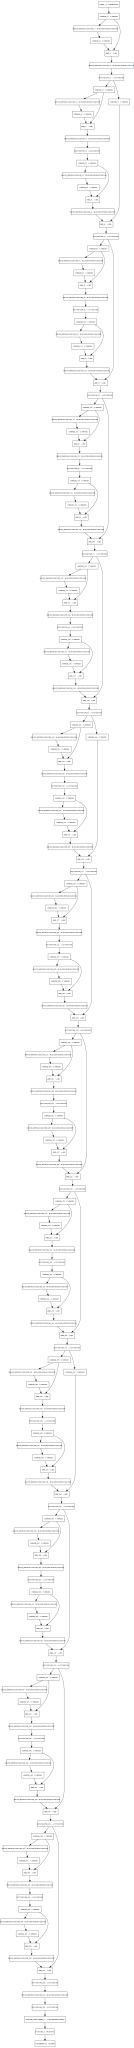

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [27]:
sgd_opt = optimizers.SGD(lr=0.1, decay=0.0005, momentum=0.0, nesterov=False)

model.compile(loss="categorical_crossentropy", optimizer=sgd_opt, metrics=["acc"])
print("Finished compiling")
print("Allocating GPU memory")
#model.load_weights("weights/WRN-28-8 Weights.h5")
#print("Model loaded.")

Finished compiling
Allocating GPU memory


In [28]:
csv_logger = callbacks.CSVLogger('training_sample.log', separator = ',', append = True)
train_files = glob.glob(data_folder + "/train/*/*")

train_steps = len(train_files)//batch_size

val_files = glob.glob(data_folder + "/val/*/*")

val_steps = len(val_files)//batch_size

print("TVsteps:", train_steps, val_steps)

filepath = "sample.h5"
#model.fit_generator(generator.flow(trainX, trainY, batch_size=batch_size), steps_per_epoch=len(trainX) // batch_size + 1, nb_epoch=nb_epoch,callbacks = [callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)],validation_data=(testX, testY),validation_steps=testX.shape[0] // batch_size,)
#model.fit_generator(train_generator, steps_per_epoch= len(train_generator), validation_data=valid_generator, validation_steps = len(valid_generator), epochs = 5, callbacks = [callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)])
model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_steps=val_steps, validation_data=valid_generator, epochs = 5, callbacks = [csv_logger, callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)])


TVsteps: 18 1
Epoch 1/5
19/18 [===============================] - 130s 7s/step - loss: 0.6992 - acc: 0.5287 - val_loss: 0.6944 - val_acc: 0.4667
Epoch 2/5
19/18 [===============================] - 60s 3s/step - loss: 0.7001 - acc: 0.4448 - val_loss: 0.6781 - val_acc: 0.7333
Epoch 3/5
19/18 [===============================] - 57s 3s/step - loss: 0.6902 - acc: 0.5836 - val_loss: 0.6512 - val_acc: 0.8000
Epoch 4/5
19/18 [===============================] - 55s 3s/step - loss: 0.6976 - acc: 0.5015 - val_loss: 0.6842 - val_acc: 0.4000
Epoch 5/5
19/18 [===============================] - 57s 3s/step - loss: 0.6873 - acc: 0.5757 - val_loss: 0.6818 - val_acc: 0.5333


# Sample model for Keras testing

In [29]:
from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

def res_adapt_mod(input):
    init=input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Convolution2D(1, (3, 3), padding='same', kernel_initializer='he_normal',
                      use_bias=False)(x)
    x = Add()([x, init])

    return x  
def initial_conv(input):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      use_bias=False, trainable = False)(input)
    x = res_adapt_mod(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', trainable = False)(x)
    x = Activation('relu', trainable=False)(x)
    return x

In [30]:
def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    return x

In [ ]:
import wide_residual_network_RAM_frozen as wrn1
init_shape = (3,img_rows, img_cols ) if K.image_dim_ordering() == 'th' else (img_rows, img_cols ,3)

model = wrn1.create_wide_residual_network(init_shape, nb_classes=classes, N=4, k=4, dropout=0.0)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [ ]:
model.fit_generator(train_generator, steps_per_epoch= len(train_generator), validation_data=valid_generator, validation_steps = len(valid_generator), epochs = nb_epoch, callbacks = [ callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)])